<a href="https://colab.research.google.com/github/RosalinaSpeedy/Twoot/blob/main/AICoursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Twoot - a 2D Convolutional Neural Network to identify 5 different American bird species based on short audio recordings of their songs
**Ben Craddock - 33733570, 13th January 2025, Goldsmiths University of London**

**Introduction**

Twoot is what I've called my AI project for this courswork submission; and it works by taking a dataset of 3 second recordings of bird songs from five different american bird species and converting them into spectrograms for analysis. Based on the analysed spectrograms - the model is trained and tested to see if it can recognise a bird species from its song.

Twoot makes use of a convolutional neural network (CNN) to learn how to classify bird species from audio - and the audio itself is read in as sound files and turned into spectrograms via Python's librosa library.

The network looks for patterns in the spectrograms and then uses its training to find the most likely mapping of spectrogram to bird species. I have implemented several 2D convolutional layers in this network to ensure that this process is effective. Furthermore - many measures have been put in place to ensure that this model is not overfitted, and is therefore robust and accurate for standardised audio samples that are 3 seconds long that align with one of the five analysed bird species.

**My code**

My code does the following:


*   Reads in audio files and converts them into standardised spectrograms
*   Processes these spectrograms into tensors for training, validation and testing datasets
*   Augments these datasets using audio augementation techniques such as gaussian noise and time and frequency masking to mimic real-world issues with audio
*   Trains several models with various levels of regularisation to reduce overfitting
*   Includes a function to tune hyperparameters of a model using random search
*   Determines the best model by processing an external piece of audio and using each model to make a prediction

**My model**

*   Takes in a 3 second spectrogram with tensor shape [None, 128, 94, 1]
*   Maps that tensor to a one-hot encoded array that corresponds to a bird species in a predefined dictionary

# Importing necessary libraries

Beginning by importing all necessary libraries and installing dependecies for the google colab environment; this step also includes ensuring that the GPU processing unit is availble for running this code on a local environment and ensuring the correct runtime is in use before further execution. This cell also mounts this notebook to my google drive to retrieve files from it using Google colab.

In [ ]:
# Birdsong recognition model using CNN - Ben Craddock 33733570
# This model is called "Twoot"

aiName = "Twoot"

print("#" * (len(aiName) * 4))
print("Welcome to " + aiName + "!")
print("#" * (len(aiName) * 4) + "\n")

#necessary imports
import os
import sys
import pathlib

import numpy as np
import tensorflow as tf
!pip install tensorflow_io
import tensorflow_io as tfio

import soundfile as sf
import scipy.signal as signal

import matplotlib.pyplot as plt

tf.get_logger().setLevel('WARNING') # https://stackoverflow.com/a/38873777

import random
import csv
import os

import librosa

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers, regularizers

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
!pip install scikeras
from scikeras.wrappers import KerasClassifier

import pickle


#Ensure the GPU is available
tf.config.list_physical_devices('GPU')
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

####################
Welcome to Twoot!
####################

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 16.1 MB/s eta 0:00:00
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2268249878535181573
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10281261203664891628
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Mounted at /content/drive


# Data

The dataset was download from:
https://www.kaggle.com/datasets/vinayshanbhag/bird-song-data-set

It features ~1000 different bird songs for the song sparrow, northern mockingbird, american robin, northern cardinal and bewick's wren respectively.

The below cells reads the included csv file that maps each file name to the data about the bird. For the purposes of this assignment I am only interested in the file name and the species name of each bird - which is column 17 and column 4 respectively.

The below function processCsv(csvIn) returns a dictionary mapping the file name to the species of the bird as seen in the output below.

In [ ]:
#import label data - modified from [1]
#dataset: https://www.kaggle.com/datasets/vinayshanbhag/bird-song-data-set
pathToCsv = "/content/drive/MyDrive/Colab Notebooks/coursework/bird_songs_metadata.csv" #csv file

def processCsv(csvIn):
    labelDict = {}
    with open(csvIn, 'r') as csv_file:
        # Read the CSV file
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row

        for index, row in enumerate(reader, start=1):
            # Ensure the row has the expected number of fields
            if len(row) != 18:
                continue  # Skip rows with unexpected format

            # Extract fields
            fileId = row[17].strip().lower()
            species = row[4].strip().lower()

            labelDict[fileId] = species
    return labelDict

labelDict = processCsv(pathToCsv)
print(labelDict)

{'557838-0.wav': "bewick's wren", '557838-1.wav': "bewick's wren", '557838-4.wav': "bewick's wren", '557838-5.wav': "bewick's wren", '557838-6.wav': "bewick's wren", '557838-8.wav': "bewick's wren", '557838-9.wav': "bewick's wren", '557838-11.wav': "bewick's wren", '557838-14.wav': "bewick's wren", '557838-15.wav': "bewick's wren", '557838-17.wav': "bewick's wren", '544036-0.wav': "bewick's wren", '544036-1.wav': "bewick's wren", '544036-2.wav': "bewick's wren", '544036-3.wav': "bewick's wren", '544036-4.wav': "bewick's wren", '544036-5.wav': "bewick's wren", '544036-6.wav': "bewick's wren", '544036-7.wav': "bewick's wren", '544036-8.wav': "bewick's wren", '544036-9.wav': "bewick's wren", '544036-10.wav': "bewick's wren", '544036-12.wav': "bewick's wren", '544036-13.wav': "bewick's wren", '493957-0.wav': "bewick's wren", '493957-1.wav': "bewick's wren", '493957-2.wav': "bewick's wren", '493957-3.wav': "bewick's wren", '493957-4.wav': "bewick's wren", '493957-5.wav': "bewick's wren", '4

**Audio conversion functions**

Because I'm dealing with raw audio (in wav format) it's important to convert this into something a CNN would understand. This process begins with the below functions:



*   createSpectrogram(filepath) is the most important function - it takes in the raw audio and uses the librosa library to return the associated mel spectrogram. This function uses a default sample rate of 16000 and the standard number of mel filters at 128 (this is to save on memory and computation time - I could have used higher quality audio but it would not have been worth it for the purposes of this demonstration). This function either pads or trims the audio as necessary to 3 seconds, and then uses the librosa library to return the spectrogram.
*   createMapping(labelDict) returns a dictionary of the index of a one hot encoded array of bird species that maps to the corresponding species, e.g.: 0: 'northern cardinal' - this is vital for training the network as it provides the basis of a data/label relationship.



In [ ]:
#convert audio to mel spectrogram [2]
def createSpectrogram(filepath, sr=16000, n_mels=128, target_length=3):
    target_length = sr * target_length
    audio, _ = librosa.load(filepath, sr=sr)
    if len(audio) < target_length:
        padding = target_length - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')
    else:
        audio = audio[:target_length]
    melSpectogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    melSpectogramDb = librosa.power_to_db(melSpectogram, ref=np.max)
    return melSpectogramDb

#convert labels names to bird name
def createMapping(labelDict):
    labels = {}
    for birdName, idx in labelDict.items():
        labels[idx] = birdName
    return labels

**Creating the basic label and species sets**

The below cell creates two sets:



*   labelsOfBirdsInDict - which has the mapping "species": index
*   birdLabelsReversed - which has the mapping index : "species"

It does this by looping over all the audio files and comparing them to the names listed in the previously defined label dictionary - if a path for the specified file exists within the given path (denoted here by the pathToData variable) - then it will be read and added to the set if it is a new species that has not yet been encountered - this was written in this way so as to expand the network if I wanted to add more than five species in the future.

In [ ]:
#generate spectograms for all birdsongs
pathToData = "/content/drive/MyDrive/Colab Notebooks/coursework/wavfiles" #wav files
testPath = "/content/drive/MyDrive/Colab Notebooks/coursework/songs/wavfiles/11713-0.wav"

data = [] #spectograms
labels = [] #accompanying bird name

# Create a set of all bird species present in the data [4]
all_bird_species = set()
for fileId, birdName in labelDict.items():
    path = os.path.join(pathToData, f"{fileId}")
    if os.path.exists(path):
        all_bird_species.add(birdName)

# Create the labels dictionary based on the species found in the data
labelsOfBirdsInLabelDict = {birdName: idx for idx, birdName in enumerate(all_bird_species)}
birdLabelsReversed = createMapping(labelsOfBirdsInLabelDict)
print(labelsOfBirdsInLabelDict)

{'northern cardinal': 0, 'song sparrow': 1, 'american robin': 2, 'northern mockingbird': 3, "bewick's wren": 4}


The below code loops through the label dictionary and creates spectrograms of all the listed file names. In the same loop - the labels are created by getting the bird species name from the according entry of the labelsOfBirdsInLabelDict set. The spectrograms are added to the data list and the labels are added to the labels list accordingly - with each index of both lists matching up; e.g., the index 1 will have a spectrogram at index 1 in the data list and the label at index 1 in the label list will have the species name that goes with that spectrogram.

Here I'm using the pickle Python library to dump the created data and label lists to Google Drive as raw data so that this spectrogram creation process need not be repeated often, as it is very time and resource intensive.

In [ ]:
#generate spectrograms (enumerate() suggested by Gemini - just to print out the progress bar)
for index, (fileId, birdName) in enumerate(labelDict.items()):
    path = os.path.join(pathToData, f"{fileId}")
    if os.path.exists(path):
        sys.stdout.write(f"\rProcessing {path} - {(index / 5423) * 100} %")
        sys.stdout.flush()
        spectogram = createSpectrogram(path)
        data.append(spectogram)
        labels.append(labelsOfBirdsInLabelDict.get(birdName))

#dumping data using pickle [5]
dataPicklePath = "/content/drive/MyDrive/Colab Notebooks/coursework/data.pickle"
with open(dataPicklePath, 'wb') as file:
    pickle.dump(data, file)

labelsPicklePath = "/content/drive/MyDrive/Colab Notebooks/coursework/labels.pickle"
with open(labelsPicklePath, 'wb') as file:
    pickle.dump(labels, file)

# Creating the workable datasets

To make my model work; I need to convert these spectrograms into something tensorflow can understand: tensors!

As such, I load in the dumped data and labels lists using the pickle library, and convert them to numpy arrays - padding the data list to ensure it has consistent length for all the saved spectrograms.

From there, I add a channel dimension to the array, thus making it four-dimensional so as to match the input shape of a 2D convolutional network. Then, split the data and labels lists into three each - for training, validation and testing with 75% of the data being reserved for training, 20% being reserved for validation and 5% for testing.

The label list is then one-hot encoded so that a label of 3, for example, becomes [0, 0, 0, 1, 0] to match with the shape of my model's output layer - this is done by using the to_categorical method.

From there the AUTOTUNE value is stored wither by importing from the keras library or the experimental keras library depending on which version is installed. This helps allocate processor usage for each dataset when applied.

Finally - each of the numpy arrays is turned into a tensorflow dataset by using the from_slices method, and applying a batch size of 32 to save on memory and processing costs. This results in a training, validation and test set all with the same shape.

In [ ]:
#pickle loading the variables [5]
dataPicklePath = "/content/drive/MyDrive/Colab Notebooks/coursework/data.pickle"
labelsPicklePath = "/content/drive/MyDrive/Colab Notebooks/coursework/labels.pickle"
data = None
labels = None
with open(dataPicklePath, 'rb') as file:
    data = pickle.load(file)
with open(labelsPicklePath, 'rb') as file:
    labels = pickle.load(file)

print("The variables have been loaded successfully.")
print(labels)

labels = np.array(labels, dtype="int")

print(labels)
print(labels.shape)

#Basis for below code adapted from GPT 4.0 free version [6]
#Padding
max_pad_len = 128
padded_data = pad_sequences(data, padding="post", truncating="post",
                            maxlen=max_pad_len, dtype="float32")

#Reshaping
data = np.array(padded_data, dtype="float32")
data = np.expand_dims(data, axis=-1)

#Split data
train_data, remaining_data, train_labels, remaining_labels = train_test_split(
    data, labels, test_size=0.25, random_state=42
)
val_data, test_data, val_labels, test_labels = train_test_split(
    remaining_data, remaining_labels, test_size=0.2, random_state=42
)

#one-hot encode the labels
speciesCount = len(np.unique(labels))
print(speciesCount)
train_labels = to_categorical(train_labels, num_classes=speciesCount)
val_labels = to_categorical(val_labels, num_classes=speciesCount)
test_labels = to_categorical(test_labels, num_classes=speciesCount)

print(train_labels)
print(val_labels)

#datasets
BATCH_SIZE = 32;
try:
    AUTOTUNE = tf.data.AUTOTUNE
except:
    AUTOTUNE = tf.data.experimental.AUTOTUNE
trainingDataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
validationDataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
testingDataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

trainingDataset = (trainingDataset
                 .batch(BATCH_SIZE)
                 .prefetch(buffer_size=AUTOTUNE))

validationDataset = (validationDataset
               .batch(BATCH_SIZE)
               .prefetch(buffer_size=AUTOTUNE))

testingDataset = (testingDataset
               .batch(BATCH_SIZE)
               .prefetch(buffer_size=AUTOTUNE))

print(f"Train Dataset: {trainingDataset}")
print(f"Validation Dataset: {validationDataset}")
print(f"Testing Dataset: {testingDataset}")

The variables have been loaded successfully.
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

**Displaying the processed spectrograms**

The below code provides a visual example of a processed spectrogram plotted using matplotlib and librosa

Shape of sample spectrogram: (128, 94)

(5422,)


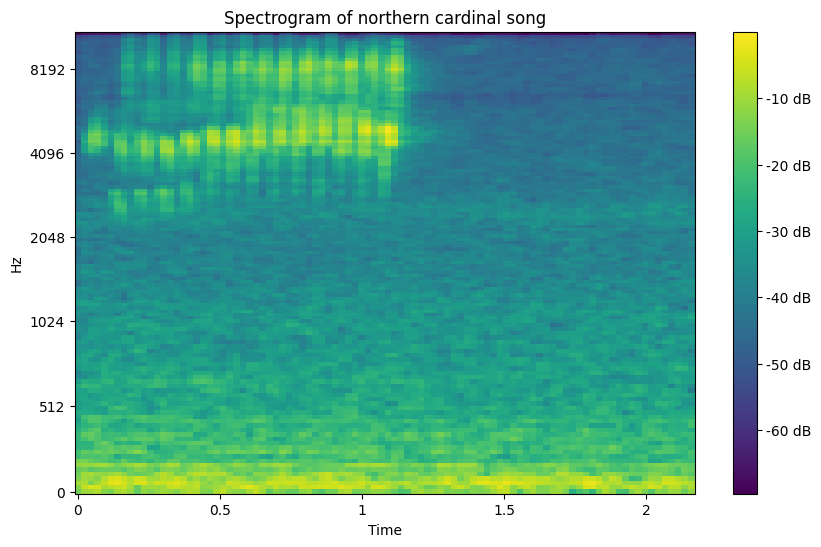

In [ ]:
%matplotlib inline
#code to visualise spectrogram taken from GPT 4.0 free version [6]
index = 5 #could be any index - just as an example
sample_spectrogram = data[index, :, :, 0]
print(f"Shape of sample spectrogram: {sample_spectrogram.shape}")
plt.figure(figsize=(10, 6))
librosa.display.specshow(sample_spectrogram, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
birdName = ''
print()

print(labels.shape)
for bird, i in labelsOfBirdsInLabelDict.items():
    if i == labels[index]:
        birdName = bird
plt.title('Spectrogram of ' + birdName + ' song')
plt.show()

# So it begins: Developing the common sense baseline

To begin making the model it is important to have a baseline - this project begins with a common sense baseline - essentially, something that is correct in its prediction about as often as you would expect if you have not told it anything at all.

This process begins with defining the basic form of the model architecture - I decided to go with a fairly simple CNN architecture using three 2D convolutional layers with three intermediate layer sets between them for batch normalisation and pooling. After which, these layers are flattened and the result is narrowed down via two further dense layers before narrowing the result of the prediction down to one of the five analysed bird species.

While this is a neural network - the common sense baseline barely makes use of all this functionality - and is rather acting as a set of steps that the model will go through before producing a prediction; as the model has not been trained yet and is just going off of 'common sense'.

In [ ]:
#reset max_pad_length - this is the 3 second length (roughly)
max_pad_len = 94
#basis for model architecture adapated from [7]
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(128, max_pad_len, 1)),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

  tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

  tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2)),

  tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2)),
  tf.keras.layers.Dense(speciesCount, activation='softmax')
])
print(model)

<Sequential name=sequential, built=True>


The below cells demonstrates how the model is compiles - using rmsprop as is standard and measuring performance based on accuracy. The compilation also uses catagorical_crossentropy as the loss function as this is the most effective for one-hot encoded labels. If I were to use sparse_catagorical_crossentropy I would be able to produce a list of probabilities as opposed to a single species, which could be more effective in theory, but as I'm only focusing on five species this is enough for my purposes.

If I were to expand Twoot in future this would be something worth considering.

In [ ]:
#stick everything together and produce a one-hot array
model.compile(
    loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 92, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 92, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 46, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 44, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 44, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 29, 20, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 29, 20, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      19,661,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,815,621 (79.41 MB)

 Trainable params: 20,814,341 (79.40 MB)

 Non-trainable params: 1,280 (5.00 KB)

**Making directories to save models**

In [ ]:
#pathing to save the callbacks:
MODELS_DIR = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/coursework/models")
MODELS_DIR.mkdir(exist_ok=True)
print("directories sorted")

directories sorted


**The common sense baseline**

As we have 5 possible species but the model essentially does not know what one is what, it is pretty much taking a random stab at predicting the species from the spectrogram. As such - you expect a rough accuracy level of 20% - which is what is produced below.

In [ ]:
#developing the common sense baseline - we are expecting a 0.2 accuracy for absolutely no training
print("Baseline Performance on Testing Set:")
test_loss, test_acc = model.evaluate(testingDataset, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")

Baseline Performance on Testing Set:
Test accuracy: 0.195


# A simple neural model that is a bit better

The next step is to try and train the defined model structure above so that it outperforms the common sense baseline.

The below cell is taken from 8. introduction to covnets; and is used to plot how well the model performs throughout the training process when comparing performance on training and validation date - plotting both accuracy and loss.

In [ ]:
#define the method to plot history - taken from 8. introduction to covnets [8]
def plot_history(history):

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, constrained_layout=True, figsize=(10,3))

    ax1.plot(epochs, accuracy,label="Training accuracy")
    ax1.plot(epochs, val_accuracy, label="Validation accuracy")
    ax1.set_title("Training and validation accuracy")
    ax1.legend()

    ax2.plot(epochs, loss,  label="Training loss")
    ax2.plot(epochs, val_loss,  label="Validation loss")
    ax2.set_title("Training and validation loss")
    ax2.legend()
    plt.show()

**Training the basic neural model**

The below code saves the model to a defined directory using callbacks that monitor the validation loss for progress - and then shuffles the training dataset for more robust results before training the simple model over 30 epochs.

As can be seen from the performance, the model performs exceptionally on the training dataset, but is less consistent on the validation data - where the accuracy does not reach the same level as it does on the training data and the loss and accuracy levels fluctate - indicating that indeed;

the model is OVERFITTING!

Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.4254 - loss: 30.0735 - val_accuracy: 0.4668 - val_loss: 9.9009
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.5545 - loss: 6.6881 - val_accuracy: 0.5378 - val_loss: 3.1519
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.6172 - loss: 2.3658 - val_accuracy: 0.4539 - val_loss: 2.0039
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.7224 - loss: 1.3289 - val_accuracy: 0.5996 - val_loss: 1.3969
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.7813 - loss: 0.9733 - val_accuracy: 0.6836 - val_loss: 1.1625
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.8394 - loss: 0.7954 - val_accuracy: 0.6753 - val_loss: 1.1444
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8731 - loss: 0.6672 - val_accuracy: 0.4788 - val_loss: 1.7180
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.9017 - loss: 0.5430 - va

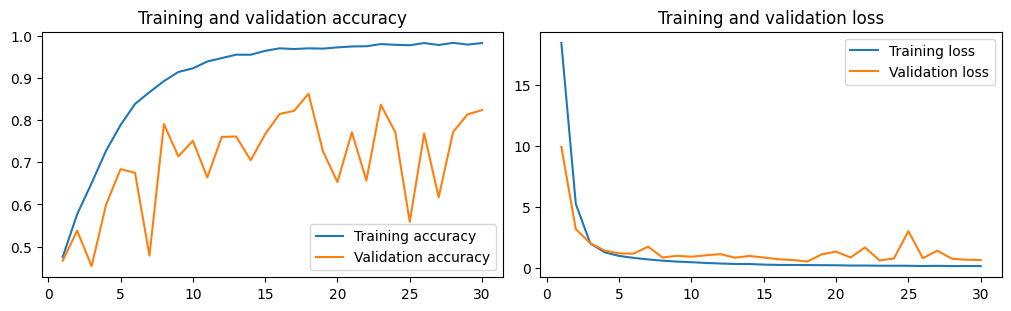

In [ ]:
#base training - simple training on the training data and seeing how it ends up
callbacks = [       #  ↓ a callback to save our best model!
    tf.keras.callbacks.ModelCheckpoint(
        filepath= str(MODELS_DIR / "basicBirdSongTrained.keras"), # name of the file
        save_best_only=True,                                        # if False you can use save_freq to save every n epochs
        monitor="val_loss"                                          # what metric to monitor
    )
]

trainingDataset = trainingDataset.shuffle(buffer_size=BATCH_SIZE) #mix em up

# Train the basic model
history = model.fit(
    trainingDataset,
    epochs = 30,
    validation_data=validationDataset,
    callbacks=callbacks
)

del model
plot_history(history)

**Evaluation of basic neural model**

Here is a test accuracy reading for the nerual model on the test dataset generated earlier. It does decently well - but we can do better.

In [ ]:
#evalution of basic training:
test_model = tf.keras.models.load_model(MODELS_DIR / "basicBirdSongTrained.keras")
test_loss, test_acc = test_model.evaluate(testingDataset, verbose=0)
print(f"Test accuracy: {test_acc:.8f}")
del test_model

Test accuracy: 0.83455884


# Regularisation - reducing overfittting: dropout

A simple way to reduce overfitting is to introduce dropout to the model. These layers randomly set inputs to zeroes at the specified frequency. To begin with - I added two simple dropout layers, one after the first dense layer and one before the output layer, with an arbitrary frequency value of 0.3.

In [ ]:
#introducing dropout layers to reduce overfitting [8]

model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(128, max_pad_len, 1)),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

  tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

  tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2)),
  tf.keras.layers.Dropout(0.3), #reduce overfitting

  tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2)),
  tf.keras.layers.Dropout(0.3), #reduce overfitting
  tf.keras.layers.Dense(speciesCount, activation='softmax')
])
print(model)

#stick everything together and produce an array of liklihoods for each species
model.compile(
    loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

model.summary()

<Sequential name=sequential_2, built=True>


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 92, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 126, 92, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 46, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 44, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 61, 44, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 31, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 29, 20, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 29, 20, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 15, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      19,661,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,815,621 (79.41 MB)

 Trainable params: 20,814,341 (79.40 MB)

 Non-trainable params: 1,280 (5.00 KB)

**Training the model with dropout**

This paid off - as can be seen from the below output the dropout layers improved performance on the validation set by a noticable margin.

Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.4207 - loss: 32.4489 - val_accuracy: 0.2731 - val_loss: 23.5823
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.5183 - loss: 11.6665 - val_accuracy: 0.4262 - val_loss: 6.8649
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.6132 - loss: 5.3625 - val_accuracy: 0.3607 - val_loss: 3.7153
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.6925 - loss: 2.8163 - val_accuracy: 0.4290 - val_loss: 2.8206
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.7477 - loss: 1.9502 - val_accuracy: 0.2362 - val_loss: 3.7808
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.7983 - loss: 1.4718 - val_accuracy: 0.5415 - val_loss: 1.8512
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.8059 - loss: 1.3300 - val_accuracy: 0.5258 - val_loss: 2.1265
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.8361 - loss: 1.1844 - v

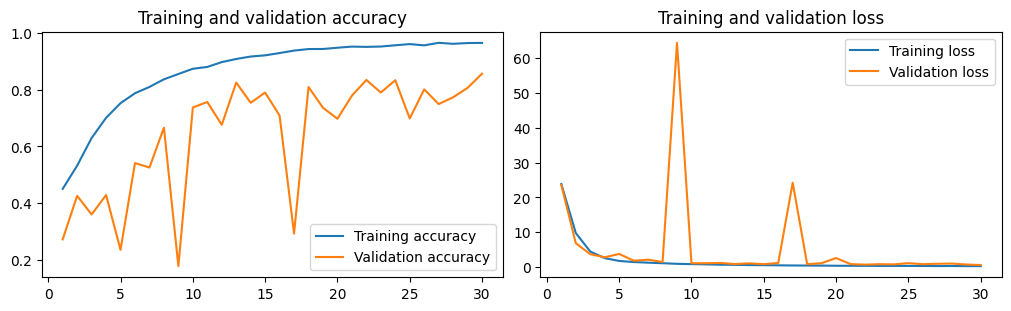

In [ ]:
#dropout layers introduced - second round of training - experiment to see if this reduces overfitting
callbacks = [       #  ↓ a callback to save our best model!
    tf.keras.callbacks.ModelCheckpoint(
        filepath= str(MODELS_DIR / "dropoutLayersBirdSongTrained.keras"), # name of the file
        save_best_only=True,                                        # if False you can use save_freq to save every n epochs
        monitor="val_loss"                                          # what metric to monitor
    )
]
#Train the model with dropout layers
history = model.fit(
    trainingDataset,
    epochs=30,
    validation_data=validationDataset,
    callbacks=callbacks
)

del model
plot_history(history)

**Testing the basic model with dropout layers**

The loss was reduced and the accuracy increased with the introduction of dropout layers, and this slightly improved performance on the testing set as can be seen below. But this is still not the best we can do.

In [ ]:
#evalution of basic training with dropout layers introduced:
test_model = tf.keras.models.load_model(MODELS_DIR / "dropoutLayersBirdSongTrained.keras")
test_loss, test_acc = test_model.evaluate(testingDataset, verbose=0)
print(f"Test accuracy: {test_acc:.8f}")
del test_model

Test accuracy: 0.86397058


# Data augmentation

To ensure that the model does not overfit - more data can be introduced that is slight variations on the standard training dataset. This is called data augmentation.

As spectrogram analysis is technically an extension of image analysis (as spectrograms are image representations of sound), I began by applying standard image augmentation to the data - as seen below.

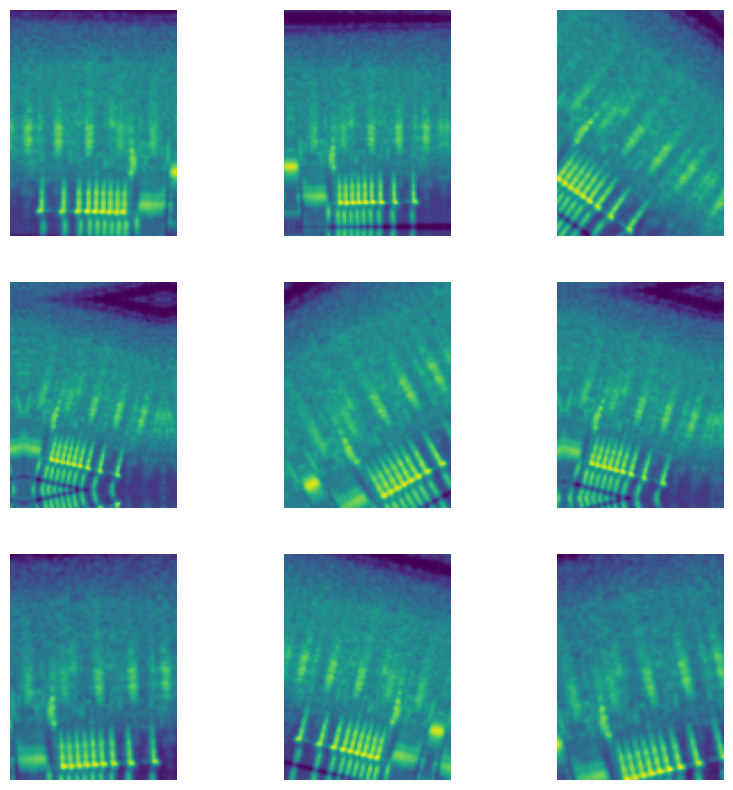

In [ ]:
#introducing data augmentation
#code taken from .8 introduction to covnets [8]
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.2)
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in trainingDataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)            # each time we run data_augmentation on images
        ax = plt.subplot(3, 3, i + 1)                           # it returns a slightly modified version
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

However, it became apparent that these augmentation techniques are not suitable for spectrograms. This is because while these do augment the image data - they are not suitable for what the image represents, that being sound. For example, flipping the audio reverses it - meaning it no longer sounds like the actual birdsong, and rotating it completely changes the timing and pitch of certain sounds. While zooming may have been suitable as it would retain the orginal shape of the sound waves - I decided it would be better to implement audio-specific augmentation methods. These being:



*   Gaussian noise - a "blur" of the audio that makes it harder to hear specific sounds - this helps mimic poor audio quality that is present in many real-world recordings
*   Frequency masking - a complete block of a specific frequency that mimics issues with real-world audio files losing data during transfer
*   Time masking - a block of a specific time interval in the audio in the same vein as the aforementioned frequency masking.

The methods for this are seen in the cell below.



In [ ]:
#better data augmentation; use augmentation specific for audio
#adapted from gpt 4.0 free version [6]

def addGaussianNoise(spectrogram, noise_level):
    noise = tf.random.normal(shape=tf.shape(spectrogram), mean=0.0, stddev=noise_level, dtype=tf.float32)
    return spectrogram + noise

def maskTime(spectrogram, maxMaskWidth=20):
    t = tf.random.uniform([], 0, maxMaskWidth, dtype=tf.int32)
    t0 = tf.random.uniform([], 0, tf.shape(spectrogram)[2] - t, dtype=tf.int32)
    mask = tf.concat([
        tf.ones((tf.shape(spectrogram)[1], t0), dtype=spectrogram.dtype),
        tf.zeros((tf.shape(spectrogram)[1], t), dtype=spectrogram.dtype),
        tf.ones((tf.shape(spectrogram)[1], tf.shape(spectrogram)[2] - t - t0), dtype=spectrogram.dtype)
    ], axis=1)
    mask = tf.expand_dims(mask, axis=-1)
    return spectrogram * mask

def maskFrequency(spectrogram, maxMaskWidth=20):
    f = tf.random.uniform([], 0, maxMaskWidth, dtype=tf.int32)
    f0 = tf.random.uniform([], 0, tf.shape(spectrogram)[1] - f, dtype=tf.int32)
    mask = tf.concat([
        tf.ones((f0, tf.shape(spectrogram)[2]), dtype=spectrogram.dtype),
        tf.zeros((f, tf.shape(spectrogram)[2]), dtype=spectrogram.dtype),
        tf.ones((tf.shape(spectrogram)[1] - f - f0, tf.shape(spectrogram)[2]), dtype=spectrogram.dtype)
    ], axis=0)
    mask = tf.expand_dims(mask, axis=-1)
    print(spectrogram)
    print(spectrogram.shape)
    print(mask)
    print(mask.shape)
    return spectrogram * mask

**Demonstrating augmentation methods**

Here is a spectrogram from the training dataset - as you can see the audio is very clear and the individual bird noises are very defined and recognisable. The next few cells will demonstrate the augmentation of data like this.

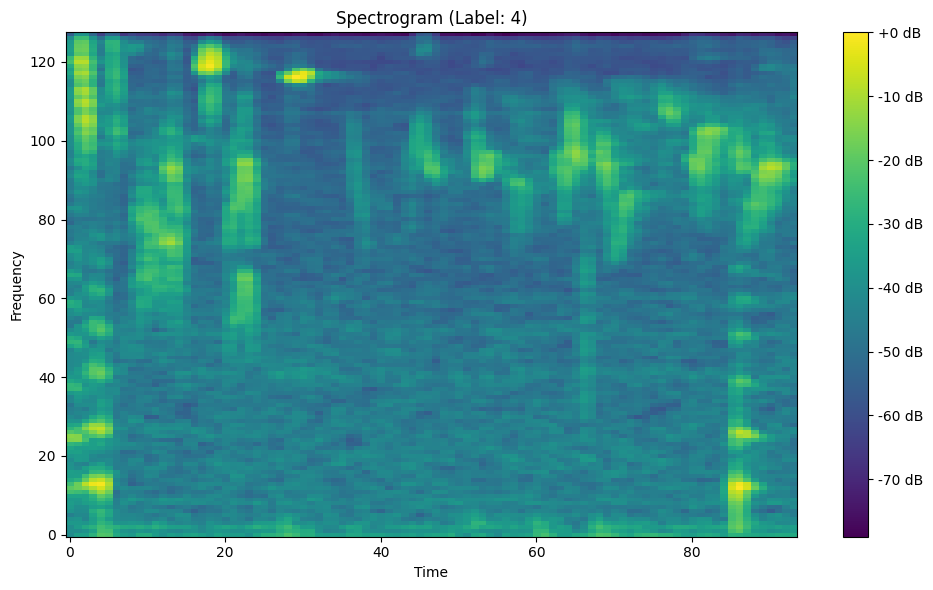

In [ ]:
# Retrieve one batch of data from the training dataset [6]
index = int(1600/32)
for spectrogram_batch, label_batch in trainingDataset.take(1):
    spectrogram = spectrogram_batch[0]
    label = label_batch[0]

# Remove the channel dimension for visualization
spectrogram = tf.squeeze(spectrogram, axis=-1)

plt.figure(figsize=(10, 6))
plt.imshow(spectrogram.numpy(), aspect='auto', origin='lower', cmap='viridis')
plt.title(f'Spectrogram (Label: {tf.argmax(label).numpy()})')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

**Creating the augmented datasets**

The goal with the below cell was to apply the predefined data augmentation methods to create a new dataset that contained both the augmented version of each spectrogram and the original one - effectively doubling the amount of data my model had to learn from. This meant more robust datasets as the model would be trained on both pristine and augmented data together - so as to help further reduce overfitting.

In [ ]:
#augment datasets - adapted from GPT 4.0 - free version [6]

def augmentDataset(spectrogram, label):
    spectrogram = addGaussianNoise(spectrogram, noise_level=3)
    spectrogram = maskFrequency(spectrogram, maxMaskWidth=10)
    spectrogram = maskTime(spectrogram, maxMaskWidth=3)
    return spectrogram, label

aug_trainingDataset = trainingDataset.map(augmentDataset, num_parallel_calls=tf.data.AUTOTUNE)
aug_trainingDataset = (aug_trainingDataset
                      .prefetch(buffer_size=AUTOTUNE))
aug_validationDataset = validationDataset.map(augmentDataset, num_parallel_calls=tf.data.AUTOTUNE)
aug_validationDataset = (aug_validationDataset
                      .prefetch(buffer_size=AUTOTUNE))
aug_testingDataset = testingDataset.map(augmentDataset, num_parallel_calls=tf.data.AUTOTUNE)
aug_testingDataset = (aug_testingDataset
                      .prefetch(buffer_size=AUTOTUNE))
print(trainingDataset)
print(aug_trainingDataset)
print(validationDataset)
print(aug_validationDataset)
print(testingDataset)
print(aug_testingDataset)

Tensor("add:0", shape=(None, 128, 94, 1), dtype=float32)
(None, 128, 94, 1)
Tensor("ExpandDims:0", shape=(None, 94, 1), dtype=float32)
(None, 94, 1)
Tensor("add:0", shape=(None, 128, 94, 1), dtype=float32)
(None, 128, 94, 1)
Tensor("ExpandDims:0", shape=(None, 94, 1), dtype=float32)
(None, 94, 1)
Tensor("add:0", shape=(None, 128, 94, 1), dtype=float32)
(None, 128, 94, 1)
Tensor("ExpandDims:0", shape=(None, 94, 1), dtype=float32)
(None, 94, 1)
<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 128, 94, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 94, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 94, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 94, 1), dtype=tf.fl

**Demonstrating the effects of data augmentation**

Below is another plot of a spectrogram from the augmented training dataset, this one has had noise, as well as time and frequency masking applied - and the difference in quality to that of the previous one is evident.

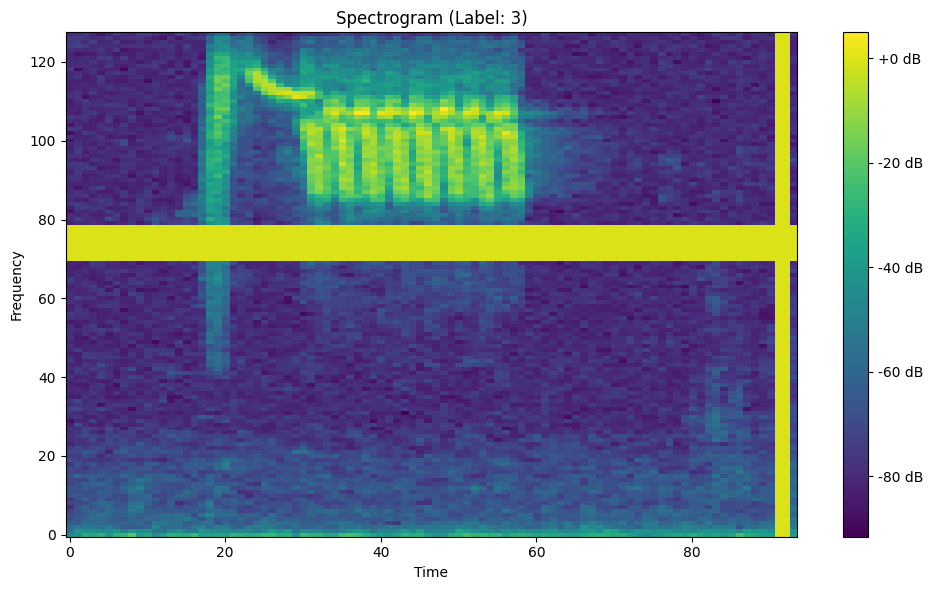

In [ ]:
# Retrieve one batch of data from the training dataset [6]
index = int(1200/32)
for spectrogram_batch, label_batch in aug_trainingDataset.take(4):
    spectrogram = spectrogram_batch[0]
    label = label_batch[0]

# Remove the channel dimension for visualization
spectrogram = tf.squeeze(spectrogram, axis=-1)

plt.figure(figsize=(10, 6))
plt.imshow(spectrogram.numpy(), aspect='auto', origin='lower', cmap='viridis')
plt.title(f'Spectrogram (Label: {tf.argmax(label).numpy()})')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

**Combining both the orginal dataset with the newly augmented one:**

In [ ]:
#combine the training dataset
combined_aug_trainingDataset = trainingDataset.concatenate(aug_trainingDataset)
combined_aug_trainingDataset = combined_aug_trainingDataset.shuffle(buffer_size=BATCH_SIZE) #mix em up

**Retrain the model using data augmentation AND dropoff layers to prevent overfitting**

<Sequential name=sequential_4, built=True>


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 126, 92, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 126, 92, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 46, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 44, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 61, 44, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 31, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 29, 20, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 29, 20, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 15, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │      19,661,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,815,621 (79.41 MB)

 Trainable params: 20,814,341 (79.40 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - accuracy: 0.4280 - loss: 29.3027 - val_accuracy: 0.2472 - val_loss: 8.4047
Epoch 2/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.5311 - loss: 4.5567 - val_accuracy: 0.3432 - val_loss: 2.8101
Epoch 3/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.7022 - loss: 1.7736 - val_accuracy: 0.5775 - val_loss: 1.8185
Epoch 4/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.8063 - loss: 1.2186 - val_accuracy: 0.6919 - val_loss: 1.4195
Epoch 5/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.8548 - loss: 0.9787 - val_accuracy: 0.5406 - val_loss: 1.8571
Epoch 6/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.8818 - loss: 0.7996 - val_accuracy: 0.5083 - val_loss: 1.9223
Epoch 7/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9098 - loss: 0.6702 - val_accuracy: 0.5803 - val_loss: 1.9645
Epoch 8/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.9225 - loss: 0.5719 

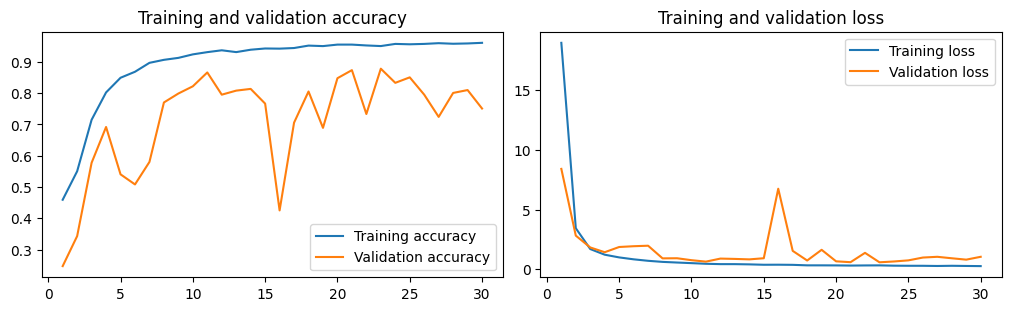

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(128, max_pad_len, 1)),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

  tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

  tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2)),
  tf.keras.layers.Dropout(0.3), #reduce overfitting

  tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2)),
  tf.keras.layers.Dropout(0.3), #reduce overfitting
  tf.keras.layers.Dense(speciesCount, activation='softmax')
])
print(model)

#stick everything together and produce an array of liklihoods for each species
model.compile(
    loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

model.summary()

#dropout layers introduced - second round of training - experiment to see if this reduces overfitting
callbacks = [       #  ↓ a callback to save our best model!
    tf.keras.callbacks.ModelCheckpoint(
        filepath= str(MODELS_DIR / "dataAugmentationBirdSongTrained.keras"), # name of the file
        save_best_only=True,                                        # if False you can use save_freq to save every n epochs
        monitor="val_loss"                                          # what metric to monitor
    )
]
# Train the model with data augmentation and dropout layers
history = model.fit(
    combined_aug_trainingDataset,
    epochs=30,
    validation_data=validationDataset,
    callbacks=callbacks
)

del model
plot_history(history)

As can be seen from the above training information and graphs, there is visible improvement on the accuracy on the validation set, but the performance is far less consistent since introducing data augmentation. This is likely due to the nature of the data changing so drasticly since introducing the augmentation. Furthermore, performance has actually seen a marginal decrease since introducing this augmentation. This indicates two things:


*   The model architecture is not perfectly suitable for the increased size of the dataset
*   The model is still overfitting



In [ ]:
#evalution of basic training with dropout layers and data augmentation introduced:
test_model = tf.keras.models.load_model(MODELS_DIR / "dataAugmentationBirdSongTrained.keras")
test_loss, test_acc = test_model.evaluate(testingDataset, verbose=0)
print(f"Test accuracy: {test_acc:.8f}")
del test_model

Test accuracy: 0.84191179


# Early stopping

The final technique I have employed to reduce overfitting is early stopping - where the training of the model is cut short to ensure that the loss value from the validation checks is kept as small as possible.

I have added this function using the callbacks as seen below, wherein the early stopping function will check for optimal performance every 5 epochs and cut the training run short if necessary.

<Sequential name=sequential_5, built=True>


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 126, 92, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 126, 92, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 63, 46, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 44, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 61, 44, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 31, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 29, 20, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 29, 20, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 15, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │      19,661,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,815,621 (79.41 MB)

 Trainable params: 20,814,341 (79.40 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - accuracy: 0.4318 - loss: 27.4696 - val_accuracy: 0.3247 - val_loss: 8.3561
Epoch 2/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.5451 - loss: 5.4460 - val_accuracy: 0.5046 - val_loss: 2.6311
Epoch 3/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.6670 - loss: 2.0893 - val_accuracy: 0.6199 - val_loss: 1.8021
Epoch 4/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.7865 - loss: 1.4047 - val_accuracy: 0.4945 - val_loss: 2.7486
Epoch 5/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.8421 - loss: 1.0537 - val_accuracy: 0.5065 - val_loss: 2.1548
Epoch 6/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.8818 - loss: 0.8311 - val_accuracy: 0.5950 - val_loss: 1.9312
Epoch 7/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.9013 - loss: 0.6898 - val_accuracy: 0.8441 - val_loss: 0.8456
Epoch 8/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.9138 - loss: 0.5864 

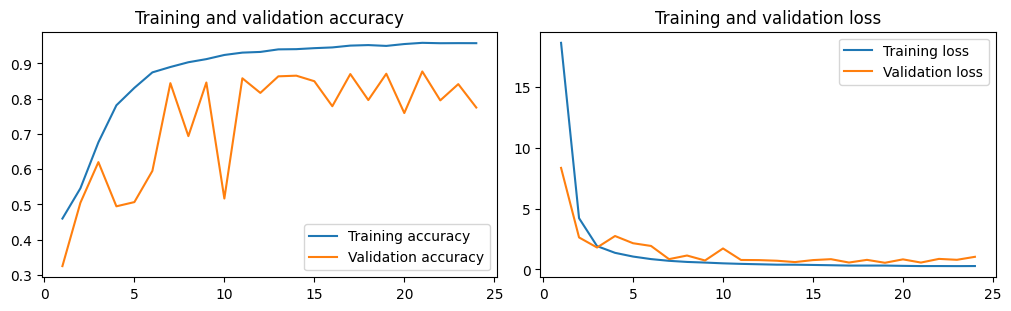

In [ ]:
#final regularisation technique - optimal stopping epoch [9]
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(128, max_pad_len, 1)),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

  tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

  tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2)),
  tf.keras.layers.Dropout(0.3), #reduce overfitting

  tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2)),
  tf.keras.layers.Dropout(0.3), #reduce overfitting
  tf.keras.layers.Dense(speciesCount, activation='softmax')
])
print(model)

#stick everything together and produce an array of liklihoods for each species
model.compile(
    loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

model.summary()

#dropout layers introduced, data augmented and now; early stopping - third round of training - experiment to see if this reduces overfitting
callbacks = [       #  ↓ a callback to save our best model (and introduce early stopping)!
    tf.keras.callbacks.ModelCheckpoint(
        filepath= str(MODELS_DIR / "earlyStoppingBirdSongTrained.keras"), # name of the file
        save_best_only=True,                                        # if False you can use save_freq to save every n epochs
        monitor="val_loss"                                          # what metric to monitor
    ),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) #add early stopping here!
]
# Train the model with data augmentation and dropout layers
history = model.fit(
    combined_aug_trainingDataset,
    epochs=30,
    validation_data=validationDataset,
    callbacks=callbacks
)

del model
plot_history(history)

**Evaluation with the introduction of early stopping:**

As you can see, this greatly improves the consistency of the performance on the validation set, and when evaluating performance on the testing dataset it has improved performance considerably when compared to the previous test.

This implies that data augmentation has helped considerably with the accuracy of the model but in the previous evaluation it had been overtrained and was therefore overfitting.

This means that overfitting has been significantly reduced and therefore performance boosted; the next step is to tune the model architecture itself to best suit the processing of the datasets for optimal performance.

In [ ]:
#evalution of basic training with dropout layers, data augmentation AND early stopping introduced:
print(MODELS_DIR / "earlyStoppingBirdSongTrained.keras")
test_model = tf.keras.models.load_model(MODELS_DIR / "earlyStoppingBirdSongTrained.keras")
test_loss, test_acc = test_model.evaluate(testingDataset, verbose=0)
print(f"Test accuracy: {test_acc:.8f}")
del test_model

/content/drive/MyDrive/Colab Notebooks/coursework/models/earlyStoppingBirdSongTrained.keras
Test accuracy: 0.89705884


# Hyperparameter tuning

Hyperparameter tuning is the process of tweaking the various numerical values used in each layer of the model so as to ensure the best possible model architecture for the dataset.

The relevant hyperparameters are:
*   learning_rate - how fast (or slow) the model learns from the training set - too fast and it won't be very smart, too slow and it may overfit - default: 0.001
*   filters - number of filters in each convolutional layer - more means bigger capacity but heavier computing power necessary
*   dropout_rate - how much of the input gets dropped when training - higher is more ruthless but less reliable - lower can contribute to overfitting
*   kernel_size - height and width of the convolutional filter - larger is better for more general abstractions while smaller is better for details
*   pool_size - affects down sampling - higher means sample dimensions get reduced quicker which can affect accuracy but also help reduce overfitting
*   units - number of units in dense layers - more is better for capacity but contributes to overfitting the higher it goes

You could search through all of the possible combinations in a grid search and determine the absolute best possible set of parameters, but this is a very costly procedure and is very time and resource consuming; therefore I decided to implement a random search to select hyperparameters from a predefined grid, as seen below.

In [ ]:
#process for hyperparameter tuning adapted from GPT 4.0 - free version [6]
#creating the grid:
grid = {
    "learning_rate": [0.001, 0.01, 0.0001, 0.1],
    "filters": [64, 128, 256, 512],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5],
    "kernel_size": [(3, 3), (5, 5)],
    "pool_size": [(2, 2), (3, 3)],
    "units": [128, 256, 512]
}

iterations = 5 #try 5 different sets

**A funtion to build a model based on the given hyperparameters:**

In [ ]:
def buildModel(learning_rate, filters, dropout_rate, kernel_size, pool_size, units):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(128, max_pad_len, 1)),
        tf.keras.layers.Conv2D(filters=int(filters / 2), kernel_size=kernel_size, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=pool_size, padding='same'),

        tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=pool_size, padding='same'),

        tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=pool_size, padding='same'),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(units=units, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2)),
        tf.keras.layers.Dropout(dropout_rate), #reduce overfitting

        tf.keras.layers.Dense(units=units, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2)),
        tf.keras.layers.Dropout(dropout_rate), #reduce overfitting
        tf.keras.layers.Dense(speciesCount, activation='softmax')
    ])
    print(model)
    optimiser = optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(
      loss="categorical_crossentropy",
      optimizer=optimiser,
      metrics=["accuracy"]
    )
    model.summary()
    return model

**Performing the random search**

Each set of randomly chosen hyperparameters is chosen from the grid, and then these hyperparameters are plugged into the above function to build a model which is trained over ten epochs - this is done five times, and whichever of the five models performs the best has the set of hyperparameters selected as the best ones for performance overall.

In [ ]:
#using random search
#using a smaller number of epochs for each iteration; saves on processing and still gives us an idea
bestValidation = 0
bestParameters = {}

for i in range(iterations):  #Random select up to the iteration value (5)
    params = {k: random.choice(v) for k, v in grid.items()}
    print("iteration: " + str(i) + f"{params}")
    print(params)
    model = buildModel(**params)
    model.fit(
        combined_aug_trainingDataset, #use the augmented set - it is better
        validation_data=validationDataset,
        epochs=10,
        verbose=1
    )
    val_accuracy = model.evaluate(validationDataset)[1]
    if val_accuracy > bestValidation:
        bestValidation = val_accuracy
        bestParameters = params
    #not using early stopping here; there are few epochs so it's unecessary
print(bestParameters)

iteration: 0{'learning_rate': 0.0001, 'filters': 64, 'dropout_rate': 0.4, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'units': 256}
{'learning_rate': 0.0001, 'filters': 64, 'dropout_rate': 0.4, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'units': 256}
<Sequential name=sequential_6, built=True>


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 126, 92, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 126, 92, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 63, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 61, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 61, 44, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 31, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 29, 20, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 29, 20, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 15, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 9600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │       2,457,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,581,317 (9.85 MB)

 Trainable params: 2,580,997 (9.85 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.4278 - loss: 8.8788 - val_accuracy: 0.4308 - val_loss: 7.5432
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6217 - loss: 6.8916 - val_accuracy: 0.5812 - val_loss: 5.8640
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7121 - loss: 5.3325 - val_accuracy: 0.6494 - val_loss: 4.7405
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7730 - loss: 4.2221 - val_accuracy: 0.6753 - val_loss: 3.8906
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8259 - loss: 3.3996 - val_accuracy: 0.7362 - val_loss: 3.1577
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8769 - loss: 2.6909 - val_accuracy: 0.7860 - val_loss: 2.5819
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9012 - loss: 2.2133 - val_accuracy: 0.8183 - val_loss: 2.1588
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9249 - loss: 1.7944 - val_ac

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 126, 92, 256)        │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 126, 92, 256)        │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 42, 31, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 40, 29, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 40, 29, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 14, 10, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 12, 8, 512)          │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 12, 8, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 4, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 6144)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │       3,146,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,959,109 (26.55 MB)

 Trainable params: 6,956,549 (26.54 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.2240 - loss: 19574.2852 - val_accuracy: 0.2306 - val_loss: 621.4729
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.1922 - loss: 2635.9954 - val_accuracy: 0.2269 - val_loss: 603.7893
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.2056 - loss: 3029.0964 - val_accuracy: 0.2177 - val_loss: 59356.9297
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.2047 - loss: 4578.3906 - val_accuracy: 0.2223 - val_loss: 240.1145
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.2164 - loss: 907.5284 - val_accuracy: 0.2177 - val_loss: 162.3146
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.2087 - loss: 2353.0813 - val_accuracy: 0.1799 - val_loss: 78.4793
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.2183 - loss: 67.6126 - val_accuracy: 0.1845 - val_loss: 78.2966
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 126, 92, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 126, 92, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 63, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 61, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 61, 44, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 31, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 29, 20, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 29, 20, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 15, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 9600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │       1,228,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,302,469 (4.97 MB)

 Trainable params: 1,302,149 (4.97 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.4365 - loss: 5.1645 - val_accuracy: 0.5101 - val_loss: 4.3670
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6483 - loss: 3.9963 - val_accuracy: 0.6125 - val_loss: 3.6444
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7350 - loss: 3.2594 - val_accuracy: 0.6467 - val_loss: 3.1122
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7984 - loss: 2.6691 - val_accuracy: 0.7288 - val_loss: 2.5666
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8354 - loss: 2.2631 - val_accuracy: 0.7186 - val_loss: 2.3268
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8805 - loss: 1.9099 - val_accuracy: 0.7998 - val_loss: 1.9111
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9064 - loss: 1.6221 - val_accuracy: 0.7851 - val_loss: 1.8139
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9297 - loss: 1.3944 - val_ac

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 124, 90, 256)        │           6,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 124, 90, 256)        │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 62, 45, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 58, 41, 512)         │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 58, 41, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 29, 21, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 25, 17, 512)         │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 25, 17, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 13, 9, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 59904)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │      15,335,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,245,957 (96.31 MB)

 Trainable params: 25,243,397 (96.30 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 126s 392ms/step - accuracy: 0.4269 - loss: 10.0621 - val_accuracy: 0.5517 - val_loss: 7.4947
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 80s 313ms/step - accuracy: 0.5873 - loss: 6.8377 - val_accuracy: 0.6439 - val_loss: 4.6911
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 82s 313ms/step - accuracy: 0.7153 - loss: 4.1954 - val_accuracy: 0.7223 - val_loss: 3.0815
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 80s 312ms/step - accuracy: 0.8132 - loss: 2.6981 - val_accuracy: 0.7186 - val_loss: 3.1614
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 80s 312ms/step - accuracy: 0.8721 - loss: 1.9230 - val_accuracy: 0.7832 - val_loss: 1.8287
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 80s 312ms/step - accuracy: 0.9100 - loss: 1.4393 - val_accuracy: 0.8690 - val_loss: 1.3647
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 82s 312ms/step - accuracy: 0.9393 - loss: 1.1025 - val_accuracy: 0.8515 - val_loss: 1.2497
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 82s 312ms/step - accuracy: 0.9620 - loss:

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 126, 92, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 126, 92, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 63, 46, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 61, 44, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 61, 44, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 31, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 29, 20, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 29, 20, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 15, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 512)                 │      19,661,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,815,621 (79.41 MB)

 Trainable params: 20,814,341 (79.40 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 74ms/step - accuracy: 0.2109 - loss: 56815.6836 - val_accuracy: 0.2269 - val_loss: 3298.0798
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.2101 - loss: 9189.6172 - val_accuracy: 0.2269 - val_loss: 17889.4570
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.2165 - loss: 13769.2871 - val_accuracy: 0.1919 - val_loss: 1572.2277
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.1964 - loss: 15081.3594 - val_accuracy: 0.1919 - val_loss: 487.6101
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.2126 - loss: 12967.5498 - val_accuracy: 0.1845 - val_loss: 6349.6299
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.2091 - loss: 7009.3979 - val_accuracy: 0.1919 - val_loss: 2057.5969
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.2060 - loss: 8212.9150 - val_accuracy: 0.1919 - val_loss: 57557.3008
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s

**Early stopping, data augmentation, dropout layers and now tuned hyperparameters**

Now that the previous cell has generated the best set of hyperparameters, it is time to properly build and train a model using those parameters using all of the other regularisation techniques employed thus far.

<Sequential name=sequential_11, built=True>


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 126, 92, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 126, 92, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 63, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 61, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 61, 44, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 31, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 29, 20, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 29, 20, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 15, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 9600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 256)                 │       2,457,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,581,317 (9.85 MB)

 Trainable params: 2,580,997 (9.85 MB)

 Non-trainable params: 320 (1.25 KB)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 126, 92, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 126, 92, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 63, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 61, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 61, 44, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 31, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 29, 20, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 29, 20, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 15, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 9600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 256)                 │       2,457,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,581,317 (9.85 MB)

 Trainable params: 2,580,997 (9.85 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.4288 - loss: 8.8623 - val_accuracy: 0.4114 - val_loss: 7.6010
Epoch 2/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6129 - loss: 6.9400 - val_accuracy: 0.4834 - val_loss: 6.1942
Epoch 3/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7060 - loss: 5.4307 - val_accuracy: 0.5637 - val_loss: 4.9749
Epoch 4/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7791 - loss: 4.2822 - val_accuracy: 0.6116 - val_loss: 4.1019
Epoch 5/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8351 - loss: 3.4117 - val_accuracy: 0.7122 - val_loss: 3.2680
Epoch 6/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8794 - loss: 2.7355 - val_accuracy: 0.7685 - val_loss: 2.6577
Epoch 7/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9120 - loss: 2.1875 - val_accuracy: 0.7758 - val_loss: 2.2354
Epoch 8/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9280 - loss: 1.7794 - val_acc

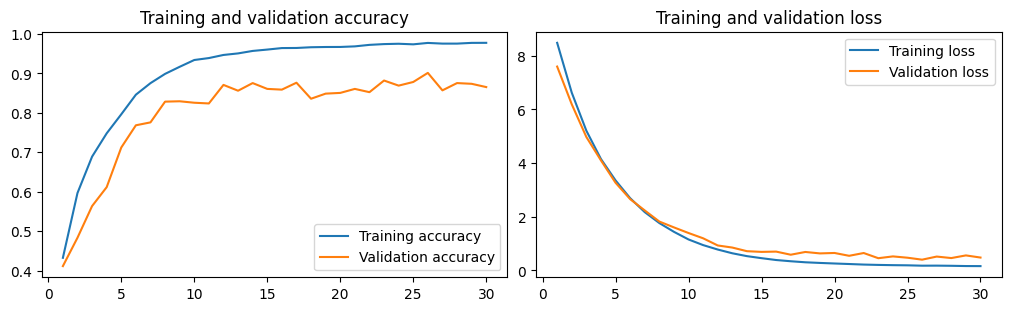

In [ ]:
#create a new model using the best parameters, early stopping, augmentation and all the trimmings
model = buildModel(**bestParameters)

model.summary()

#dropout layers introduced, data augmented and now; early stopping - third round of training - experiment to see if this reduces overfitting
callbacks = [       #  ↓ a callback to save our best model (and introduce early stopping)!
    tf.keras.callbacks.ModelCheckpoint(
        filepath= str(MODELS_DIR / "TunedAndTrained.keras"), # name of the file
        save_best_only=True,                                        # if False you can use save_freq to save every n epochs
        monitor="val_loss"                                          # what metric to monitor
    ),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) #add early stopping here!
]
# Train the model with data augmentation and dropout layers
history = model.fit(
    combined_aug_trainingDataset,
    epochs=30,
    validation_data=validationDataset,
    callbacks=callbacks
)

del model
plot_history(history)

**Evaluation of the final model:**

From the training output above it is clear that the tuning of hyperparameters led to a noticable increase in consistency in performance on the validation dataset and far less loss; which means that overfitting has been reduced significantly thanks to all these regularisation and tuning techniques.

This is further exemplified by the accuracy output seen below when evaluating this final model on the test dataset - over 90% is excellent.

In [ ]:
#evalution of basic training with dropout layers, data augmentation, tuning AND early stopping introduced:
test_model = tf.keras.models.load_model(MODELS_DIR / "TunedAndTrained.keras")
test_loss, test_acc = test_model.evaluate(testingDataset, verbose=0)
print(f"Test accuracy: {test_acc:.8f}")
del test_model

Test accuracy: 0.90441179


# Using the final model

To test the final model I have downloaded a bewick's wren call from here:
https://xeno-canto.org/species/Thryomanes-bewickii

This is completely seperate from the training, validation and testing datasets - I downloaded the file and trimmed the silence using Audacity.

As this is a completely seperate file it needs to be normalised so the model can process it - into having 22050 samples per second and being mono channel; as this is a stereo file.

In [ ]:
#using the model
#This is testing the trained model on something that it *should* know, but hasn't been shown, validated on or tested with

#This is a bewick's wren call downloaded from https://xeno-canto.org/species/Thryomanes-bewickii
#The silence was trimmed out using Audacity
#That is a completely seperate source from the dataset - so it needs to be normalised:
#22050 samples/sec and it needs to be single channel
#basis for loading and updating sample rates [10]
pathToTestAudio = "/content/drive/MyDrive/Colab Notebooks/coursework/XC885252.wav"
audio, originalSampleRate = librosa.load(pathToTestAudio, sr=None, mono=False)
if originalSampleRate != 22050:
    audio = librosa.resample(audio, orig_sr=originalSampleRate, target_sr=22050)

if audio.ndim > 1:
    audio = librosa.to_mono(audio)
outputFilepath = "/content/drive/MyDrive/Colab Notebooks/coursework/XC885252R.wav"
sf.write(outputFilepath, audio, 22050)
print(f"Modified audio saved to {outputFilepath}")

Modified audio saved to /content/drive/MyDrive/Colab Notebooks/coursework/XC885252R.wav


**The external birdsong file spectrogram**

(128, 94)
Shape of sample spectrogram: (128, 94)


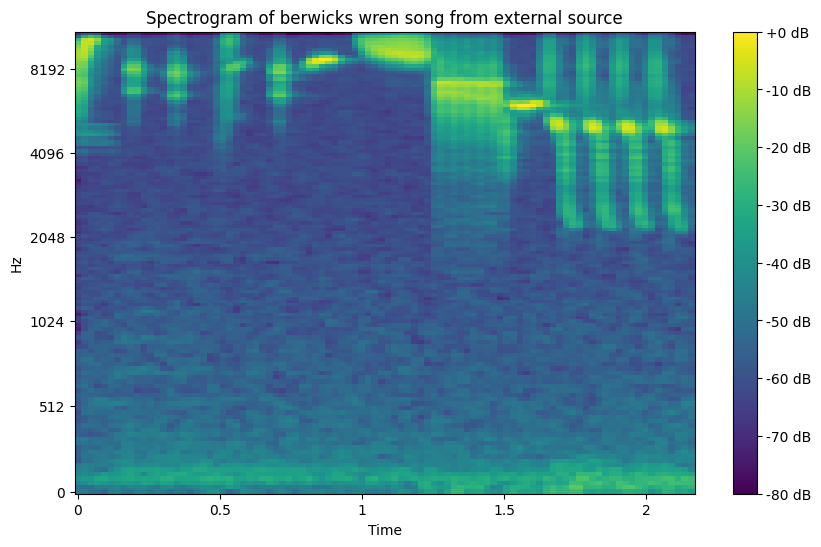

(128, 94)


In [ ]:
testSpectrogram = createSpectrogram(pathToTestAudio)
print(testSpectrogram.shape)

# Extract a sample spectrogram from the testing dataset [6]
%matplotlib inline
print(f"Shape of sample spectrogram: {testSpectrogram.shape}")
plt.figure(figsize=(10, 6))
librosa.display.specshow(np.squeeze(testSpectrogram), x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of berwicks wren song from external source')
plt.show()

print(testSpectrogram.shape)
testSpectrogram = np.expand_dims(testSpectrogram, axis=-1)
testSpectrogram = np.expand_dims(testSpectrogram, axis=0)

**Evaluating each model against the unseen data**

This cell demonstrates each of the different models performance on the unseen, external spectrogram. As seen below, all models performed well besides the fourth model - which was the one that suffered from evident overfitting - and therefore the incorrect output and lower confidence level is to be expected.

From this output - it is evident that the final model with all regularisation techniques and hyperparameter tuning applied is the best one, as it made the correct prediction with the highest level of confidence.

In [ ]:
print(testSpectrogram.shape)
#predict what the unseen data is:
print("BASIC MODEL:")
test_model = tf.keras.models.load_model(MODELS_DIR / "basicBirdSongTrained.keras")
prediction = test_model.predict(testSpectrogram)
predictedClass = np.argmax(prediction)
confidence = np.max(prediction)
print()
print(f"predicted bird: {birdLabelsReversed.get(predictedClass)}, confidence: {confidence:.8f}")
del test_model

print("BASIC MODEL WITH DROPOUT LAYERS:")
test_model = tf.keras.models.load_model(MODELS_DIR / "dropoutLayersBirdSongTrained.keras")
prediction = test_model.predict(testSpectrogram)
predictedClass = np.argmax(prediction)
confidence = np.max(prediction)
print()
print(f"predicted bird: {birdLabelsReversed.get(predictedClass)}, confidence: {confidence:.8f}")
del test_model

print("BASIC MODEL WITH DATA AUGMENTATION AND DROPOUT LAYERS:")
test_model = tf.keras.models.load_model(MODELS_DIR / "dataAugmentationBirdSongTrained.keras")
prediction = test_model.predict(testSpectrogram)
predictedClass = np.argmax(prediction)
confidence = np.max(prediction)
print()
print(f"predicted bird: {birdLabelsReversed.get(predictedClass)}, confidence: {confidence:.8f}")
del test_model

print("BASIC MODEL WITH DATA AUGMENTATION AND DROPOUT LAYERS AND EARLY STOPPING:")
test_model = tf.keras.models.load_model(MODELS_DIR / "earlyStoppingBirdSongTrained.keras")
prediction = test_model.predict(testSpectrogram)
predictedClass = np.argmax(prediction)
confidence = np.max(prediction)
print()
print(f"predicted bird: {birdLabelsReversed.get(predictedClass)}, confidence: {confidence:.8f}")
del test_model

print("BASIC MODEL WITH DATA AUGMENTATION AND DROPOUT LAYERS AND EARLY STOPPING AND HYPERPARAMETER TUNING:")
test_model = tf.keras.models.load_model(MODELS_DIR / "TunedAndTrained.keras")
prediction = test_model.predict(testSpectrogram)
predictedClass = np.argmax(prediction)
confidence = np.max(prediction)
print()
print(f"predicted bird: {birdLabelsReversed.get(predictedClass)}, confidence: {confidence:.8f}")
del test_model

(1, 128, 94, 1)
BASIC MODEL:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step



NameError: name 'birdLabelsReversed' is not defined

# Conclusion

In conclusion, the final model effectively solves classification of the five different bird species based on audio spectrograms - and this was achieved by implementing several regularisation techniques and hyperparameter tuning on an augmented dataset - to in turn ensure that the model had a varied dataset to learn from with hyperparameters tailored for it; as well as decent measures to prevent overfitting.

The model is built around a two-dimensional CNN, which is well suited for spectrogram classification tasks such as this one as spectrograms are a type of image - and 2D CNN's are well established as a good option for image classification tasks. However, as spectrograms are special images that represent audio data - it was important to realise that tradition data augmentation methods such as zoom, flip and rotate were not suitable; as these would too drastically change the audio representation and skew the results of the training. Therefore, I instead implemented methods for gaussian noise and frequency/time masking - which are specifically suited for audio data augmentation to help reduce overfitting.

Overfitting is further reduced by the introduction of dropout layers and early stopping. Which leads to accurate results on unseen data.

A challenge when developing this model was with hyperparameter tuning - as to get the best possible hyperparameters it would have been an extremely costly process to grid search for all possible options - therefore I implemented a random search to get a set of parameters that, while possibly not the absolute best, were a noticable improvement over no tuning at all.

This project utilises and preproccesses a large external dataset and efficiently generalises the data into readable spectrograms that the model can train and test with.

Future expansions for this model could include the introduction of analysis for more bird species, or for longer audio recordings. More complicated adjustments may include further generalisations for the data - as of right now the model cannot accurately predict a bird species if the audio is too sparse - which is somewhat unrealistic for how bird songs actually sound. Furthermore, the introdcution of branch selection and sparse catagorical crossentropy to produce an array of probabilities rather than a mapping to a one-hot vector could be preferable in future, as this would allow the model to make more accurate predictions based on data with less clarity.

Overall, I believe that this model solves the problem of classifying five different bird species based on their songs to a reasonably well extent due to the high accuracy scores and low loss scores of the final model I have produced.

# References

1.   https://docs.python.org/3/library/csv.html
2.   https://www.kaggle.com/code/rtatman/how-to-create-spectrograms-from-flac-files   
3.   https://www.geeksforgeeks.org/how-to-use-pickle-to-save-and-load-variables-in-python/
4.   https://www.geeksforgeeks.org/python-loop-through-folders-and-files-in-directory/
5.   https://www.geeksforgeeks.org/how-to-use-pickle-to-save-and-load-variables-in-python/
6.   https://chatgpt.com/share/677ef015-e6c4-8011-930d-4113ed8a1cda (this is a link to my entire usage of ChatGPT (4.0 - free version) for this assignment; the conversations were used here to give me a starting point for the work and adapted from there, the link is here for transparency purposes to show my entire process and from where I got all my information).
7.   https://www.kaggle.com/code/arifmia/hybrid-deep-learning-approaches-for-bird-species-c#Data-Preprocessing
8.   https://drive.google.com/file/d/11y1ArxRvAbd0FM9lXog0j21RSYwAQeVu/view?usp=sharing
9.   https://keras.io/api/callbacks/early_stopping/
10.  https://stackoverflow.com/questions/38188359/sampling-rate-issue-with-librosa



# Data

Main dataset: https://www.kaggle.com/datasets/vinayshanbhag/bird-song-data-set

External bird song: https://xeno-canto.org/885252/download